In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # import KFold
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as Pipeline
from sklearn.model_selection import validation_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests, json, random, time, tqdm, warnings
seed=111

### Christian ###
# path='/Users/Christian/Dropbox/Universitet/TSODAS/TSDS-gruppe-2019/Exam/'

### Thor ###
path='C:/Users/thorn/OneDrive/Dokumenter/GitHub/TSDS-gruppe-2019/Exam/'

### Loading data

In [2]:
r1=pd.read_pickle(path+'Scraping/prices_0_200.pkl')
r2=pd.read_pickle(path+'Scraping/prices_200_578.pkl')
r3=pd.read_pickle(path+'Scraping/prices_577_777.pkl')
r4=pd.read_pickle(path+'Scraping/prices_777_1000.pkl')
r5=pd.read_pickle(path+'Scraping/prices_1000_1500.pkl')
r6=pd.read_pickle(path+'Scraping/prices_1500_2000.pkl')
r7=pd.read_pickle(path+'Scraping/prices_2000_3000.pkl')
r8=pd.read_pickle(path+'Scraping/prices_3000_3240.pkl')
r9=pd.read_pickle(path+'Scraping/prices_3240_4000.pkl')
r10=pd.read_pickle(path+'Scraping/prices_4000_.pkl')
#print(len(r1), len(r2), len(r3), len(r4), len(r5), len(r6))
r=r1.append(r2, ignore_index=True)
r=r.append(r3, ignore_index=True)
r=r.append(r4, ignore_index=True)
r=r.append(r5, ignore_index=True)
r=r.append(r6, ignore_index=True)
r=r.append(r7, ignore_index=True)
r=r.append(r8, ignore_index=True)
r=r.append(r9, ignore_index=True)
r=r.append(r10, ignore_index=True)

r.to_pickle('scraping_data.pkl')

### Cleaning

In [3]:
r=pd.read_pickle('scraping_data.pkl')
t=pd.read_pickle(path+'Scraping/missings_190528.pkl')
r=r.append(t, ignore_index=True)
missings2018_1= pd.read_pickle(path+'Scraping/missings_2018_del1.pkl')
missings2018_2= pd.read_pickle(path+'Scraping/missings_2018_del2.pkl')
missings2018_3= pd.read_pickle(path+'Scraping/missings_2018_del3.pkl')
r=r.append(missings2018_1, ignore_index=True)
r=r.append(missings2018_2, ignore_index=True)
r=r.append(missings2018_3, ignore_index=True)

r=r.loc[(r.price !='-') & (r.price != 'Ingen')]
r=r.drop_duplicates(['origin','destination'])
r['price']=r['price'].str[4:].str.replace('.','')
r['price']=pd.to_numeric(r.price, errors='coerce')
r=r.drop_duplicates(['origin','destination'])
pred=pd.read_pickle(path+'Data/FlightsNx18.pkl')

pred_data=r.merge(pred, how='right', left_on=['origin','destination'], right_on=['Origin', 'Dest'])


missings = pred_data[pred_data['price'].isna()==True]
missings = missings[missings['count']>52]
missings = missings[missings['day'].isna()==True]
missings = missings[['Origin','Dest']]
missings.to_pickle(path+'Scraping/missings18.pkl')
pred_data=pred_data[pred_data['count']>=52]
pred_data = pred_data[pred_data['price'].isna()!=True]
pred_data = pred_data[pred_data['price']<5000]
pred_data.to_pickle('pred_data_2018.pkl')
missings

,Origin,Dest
5447,OGG,ORD
5448,EWR,JAC
5449,ORD,OGG
5459,PHX,PDX
5460,OAK,OGG
5461,ADK,ANC
5462,ANC,ADK
5463,KOA,SAN
5465,SAN,KOA
5468,LGA,PWM


### Exploring data

In [4]:
X_base=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights','Origin','Dest', 'label']]
y_base=pred_data['price']

X=pred_data[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef', 'Origin','Dest', 'label']]
y=pred_data['price']

X_base=pd.get_dummies(data=X_base, columns=['Origin', 'Dest', 'label'])
X=pd.get_dummies(data=X, columns=['Origin', 'Dest', 'label'])
#X.drop(['Origin','Dest'], inplace=True, axis=1)

(array([ 416., 1073., 1232., 1079.,  605.,  408.,  178.,   52.,   38.,
          17.]),
 array([ 189. ,  665.3, 1141.6, 1617.9, 2094.2, 2570.5, 3046.8, 3523.1,
        3999.4, 4475.7, 4952. ]),
 <a list of 10 Patch objects>)

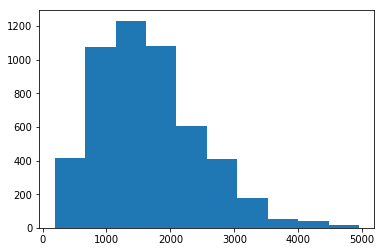

In [5]:
plt.hist(y)

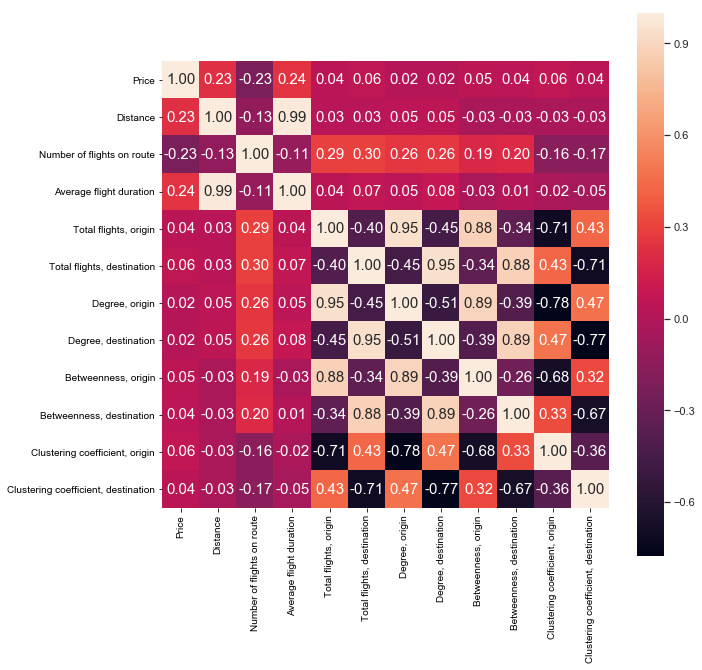

In [6]:
# Look at the Correlation matrix
cols = ['price','Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns', 'origin_clustcoef', 'dest_clustcoef']
names = ['Price', 'Distance', 'Number of flights on route', 'Average flight duration', 'Total flights, origin',
        'Total flights, destination', 'Degree, origin', 'Degree, destination', 'Betweenness, origin',
        'Betweenness, destination', 'Clustering coefficient, origin', 'Clustering coefficient, destination']
fig4, hm = plt.subplots(figsize=(10,10))
cm = np.corrcoef(pred_data[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15}, yticklabels=names, xticklabels=names)
plt.savefig(path+"Figures/corr_plot.pdf", bbox_inches='tight')


In [7]:
# Splitting the data into test and training
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=1)
X_dev_base, X_test_base, y_dev_base, y_test_base = train_test_split(X_base, y_base, test_size=1/4, random_state=1)

print(len(y_test_base), len(X_test_base))
print(X_test_base)

1275 1275
      Distance  count  avg_time_mins  Origin_flights  Destination_flights  \
4059     382.0    662      99.444268           15103               284883   
2354     214.0   4181      64.683654          147015               766993   
4959    1468.0    661     198.835637          103552               155339   
4        605.0   3964     116.982969           92726               277642   
3075     524.0    199     109.974227           33872               263507   
4940     249.0   1696      58.327183          169682                98151   
153      358.0   2759      71.708624           52203                92726   
616      345.0   3459      70.547488           35494               322459   
2567    1066.0   1270     159.811548           63893               266385   
1215     509.0   1287      97.839044          341089                 9607   
1887     679.0   9186     127.618916          277642               346640   
2850    1589.0   2731     248.602795          314881              

[1275 rows x 692 columns]


In [8]:
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_dev, y_dev)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_test)
r2 = gm_cv.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.43057489977298663
Tuned ElasticNet MSE: 363227.2991517201


In [9]:
#Without network

# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet()

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_dev_base, y_dev_base)

# Predict on the test set and compute metrics
y_pred_base = gm_cv.predict(X_test_base)
r2 = gm_cv.score(X_test_base, y_test_base)
mse = mean_squared_error(y_test_base, y_pred_base)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

Tuned ElasticNet l1 ratio: {'l1_ratio': 1.0}
Tuned ElasticNet R squared: 0.42683039306945025
Tuned ElasticNet MSE: 365615.86097668845


In [10]:
# Model with polynomial features
# Import necessary modules
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
# Polynomial transformation


quadratic = PolynomialFeatures(degree=2)
X_quad_dev = quadratic.fit_transform(X_dev[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef']])
X_quad_dev = pd.DataFrame(X_quad_dev)
X_dev_drop = X_dev.drop(['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef'], axis=1)
X_dev_drop = X_dev_drop.reset_index()
X_quan_dev = pd.concat([X_quad_dev, X_dev_drop], axis=1, ignore_index=True)

X_quad_test = quadratic.fit_transform(X_test[['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef']])
X_quad_test = pd.DataFrame(X_quad_test)
X_test_drop = X.drop(['Distance','count', 'avg_time_mins', 'Origin_flights', 'Destination_flights', 'origin_degree', 
        'dest_degree', 'origin_btwns', 'dest_btwns','origin_clustcoef', 'dest_clustcoef'], axis=1)
X_test_drop = X_test_drop.reset_index()
X_quan_test = pd.concat([X_quad_test, X_test_drop], axis=1, ignore_index=True)


# Create the hyperparameter grid
l1_space = np.linspace(0, 1, 30)

param_grid = [{'l1_ratio': l1_space}]

# Instantiate the ElasticNet regressor: elastic_net
elastic_net = ElasticNet(alpha=30)

# Setup the GridSearchCV object: gm_cv
gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)

# Fit it to the training data
gm_cv.fit(X_quan_dev, y_dev)

# Predict on the test set and compute metrics
y_pred = gm_cv.predict(X_quan_test)
r2 = gm_cv.score(X_quan_test, y_test)
mse = mean_squared_error(y_test, y_pred)
print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))
print("Tuned ElasticNet MSE: {}".format(mse))

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

C:\Users\thorn\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').